### In this notebook I try to solve the problem of discrimating similar languages using gradient boosted decision tree  <a href="https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf">(Paper)</a> 

***

I have chosen DSLCC4.0 dataset and specifically spanish language variant with 3 versions [ es-AR (argentine) , es-PE (peruvian) , es-ES (castilian) ]  

In [1]:
import pandas as pd
from collections import Counter
import lightgbm as lgb
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import scipy as sc
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from string import punctuation
import re 
import nltk
import warnings
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /home/Soumya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Dataset

In [3]:
df_train = pd.read_csv("dsl/DSL-TRAIN.txt",sep="\t",header=None)
df_eval = pd.read_csv("dsl/DSL-DEV.txt",sep="\t",header=None)

df_test = pd.read_csv("dsl/DSL-TEST-GOLD.txt",sep="\t",header=None)

- Preprocessing Scripts
- Extract target data in a dataframe
- Normalise text

In [4]:
def filter_language(lang):
    if lang in ["es-AR","es-ES","es-PE"]:
        return 1
    elif lang in ["fr-CA","fr-FR"]:
        return 2
    else:
        return 3

def remove_punc(comment):
    comment = re.sub(r"[\*\"\n\\\+\-\/\=\(\):\[\]\|\!;]", "",comment)
    comment = re.sub(r"\,", "", comment)
    comment = re.sub(r"\.", "", comment)
    comment = re.sub("^\ ","",comment)
    comment = re.sub("\d+","",comment)
    return comment

In [5]:
df_train = df_train.rename(columns={0:"Text",1:"language"})
df_eval = df_eval.rename(columns={0:"Text",1:"language"})

df_test = df_eval.rename(columns={0:"Text",1:"language"})

In [6]:
df_train["Meta_lang_tag"] = df_train["language"].apply(filter_language)
df_eval["Meta_lang_tag"] = df_eval["language"].apply(filter_language)
df_test["Meta_lang_tag"] = df_test["language"].apply(filter_language)

In [7]:
df_train_spanish = df_train[df_train["Meta_lang_tag"] == 1]
df_eval_spanish = df_eval[df_eval["Meta_lang_tag"] == 1]
df_test_spanish = df_test[df_test["Meta_lang_tag"] == 1]


df_train_spanish["normalised_text"] = df_train_spanish["Text"].apply(remove_punc)
df_eval_spanish["normalised_text"] = df_eval_spanish["Text"].apply(remove_punc)
df_test_spanish["normalised_text"] = df_test_spanish["Text"].apply(remove_punc)



df_train_spanish = shuffle(df_train_spanish)
df_eval_spanish = shuffle(df_eval_spanish)
df_test_spanish = shuffle(df_test_spanish)


le = LabelEncoder()  # Convert string label to integer
le.fit(df_train_spanish["language"])

df_train_spanish.insert(len(df_train_spanish.columns),"label",
                  le.transform(df_train_spanish["language"]))


df_eval_spanish.insert(len(df_eval_spanish.columns),"label",
                  le.transform(df_eval_spanish["language"]))


df_test_spanish.insert(len(df_test_spanish.columns),"label",
                  le.transform(df_test_spanish["language"]))

## Feature engineering 
- Tf-Idf of character ngram (3-7) with atleast count frequency 100. Lowering threshold leads to explotion of features which can lead to overfitting. 

- High Frequency char ngram discarded (possibly stop words)

- Tf-Idf of words ( Rare and high occuring words are discarded)

- The basic intution is that difference between versions of the same language can be captured by statistical differences in character sequences. Also there could be orthographic difference in the same word in both language ( Common in English variants)  

In [8]:
vectorizer1 = TfidfVectorizer(analyzer='char',ngram_range=(3,7),
                              lowercase=True,
                             strip_accents='ascii',min_df=100,
                              max_df=300,encoding="ascii",
                            decode_error="replace",dtype=np.float32)



vectorizer2 = TfidfVectorizer(analyzer='word',ngram_range=(1,1),
                              lowercase=True,
                             strip_accents='ascii',min_df=25,
                              max_df=300,encoding="ascii",
                            decode_error="replace",dtype=np.float32)




vectorizer1.fit(df_train_spanish["normalised_text"])
vectorizer2.fit(df_train_spanish["normalised_text"])


TfidfVectorizer(decode_error='replace', dtype=<class 'numpy.float32'>,
                encoding='ascii', max_df=300, min_df=25, strip_accents='ascii')

In [9]:
X_train2 = vectorizer1.transform(df_train_spanish["normalised_text"])
X_eval2 = vectorizer1.transform(df_eval_spanish["normalised_text"])
X_test2 = vectorizer1.transform(df_test_spanish["normalised_text"])


In [10]:
X_train3 = vectorizer2.transform(df_train_spanish["normalised_text"])
X_eval3 = vectorizer2.transform(df_eval_spanish["normalised_text"])
X_test3 = vectorizer2.transform(df_test_spanish["normalised_text"])


In [11]:
feature_name1 = vectorizer1.get_feature_names()
feature_name2 = vectorizer2.get_feature_names()

In [12]:
feature_name = feature_name1 + feature_name2

## Prepare Train / Validation / Test Data Matrix

In [13]:

XTrain = np.concatenate((X_train2.toarray(),X_train3.toarray()),axis=1)
XEval = np.concatenate((X_eval2.toarray(),X_eval3.toarray()),axis=1)
XTest = np.concatenate((X_test2.toarray(),X_test3.toarray()),axis=1)


## Prepare Train / Validation / Test Data Matrix Labels

In [14]:
YTrain = df_train_spanish["label"].to_numpy()
YEval = df_eval_spanish["label"].to_numpy()
YTest = df_test_spanish["label"].to_numpy()

## Classifier Object 

In [15]:
classifier = lgb.LGBMClassifier(boosting_type='gbdt',objective='multiclass',
                                learning_rate=0.04,
                               max_bin=512,
                                bagging_fraction=0.8,
                                feature_fraction=0.8,
                               lambda_l1=1e-6,num_iterations=3000,n_jobs=6)

## Training Loop with early stopping

In [17]:
eval_result = {}
classifier.fit(XTrain,YTrain,eval_set=[(XTrain,YTrain),(XEval,YEval)],
               eval_names=["train","validation"],
               feature_name=feature_name,early_stopping_rounds=100,
              callbacks=[lgb.record_evaluation(eval_result)],verbose=False)
               

LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.8, lambda_l1=1e-06,
               learning_rate=0.04, max_bin=512, n_jobs=6, num_iterations=3000,
               objective='multiclass')

## Visualize training / Validation Loss

<Figure size 2160x1440 with 0 Axes>

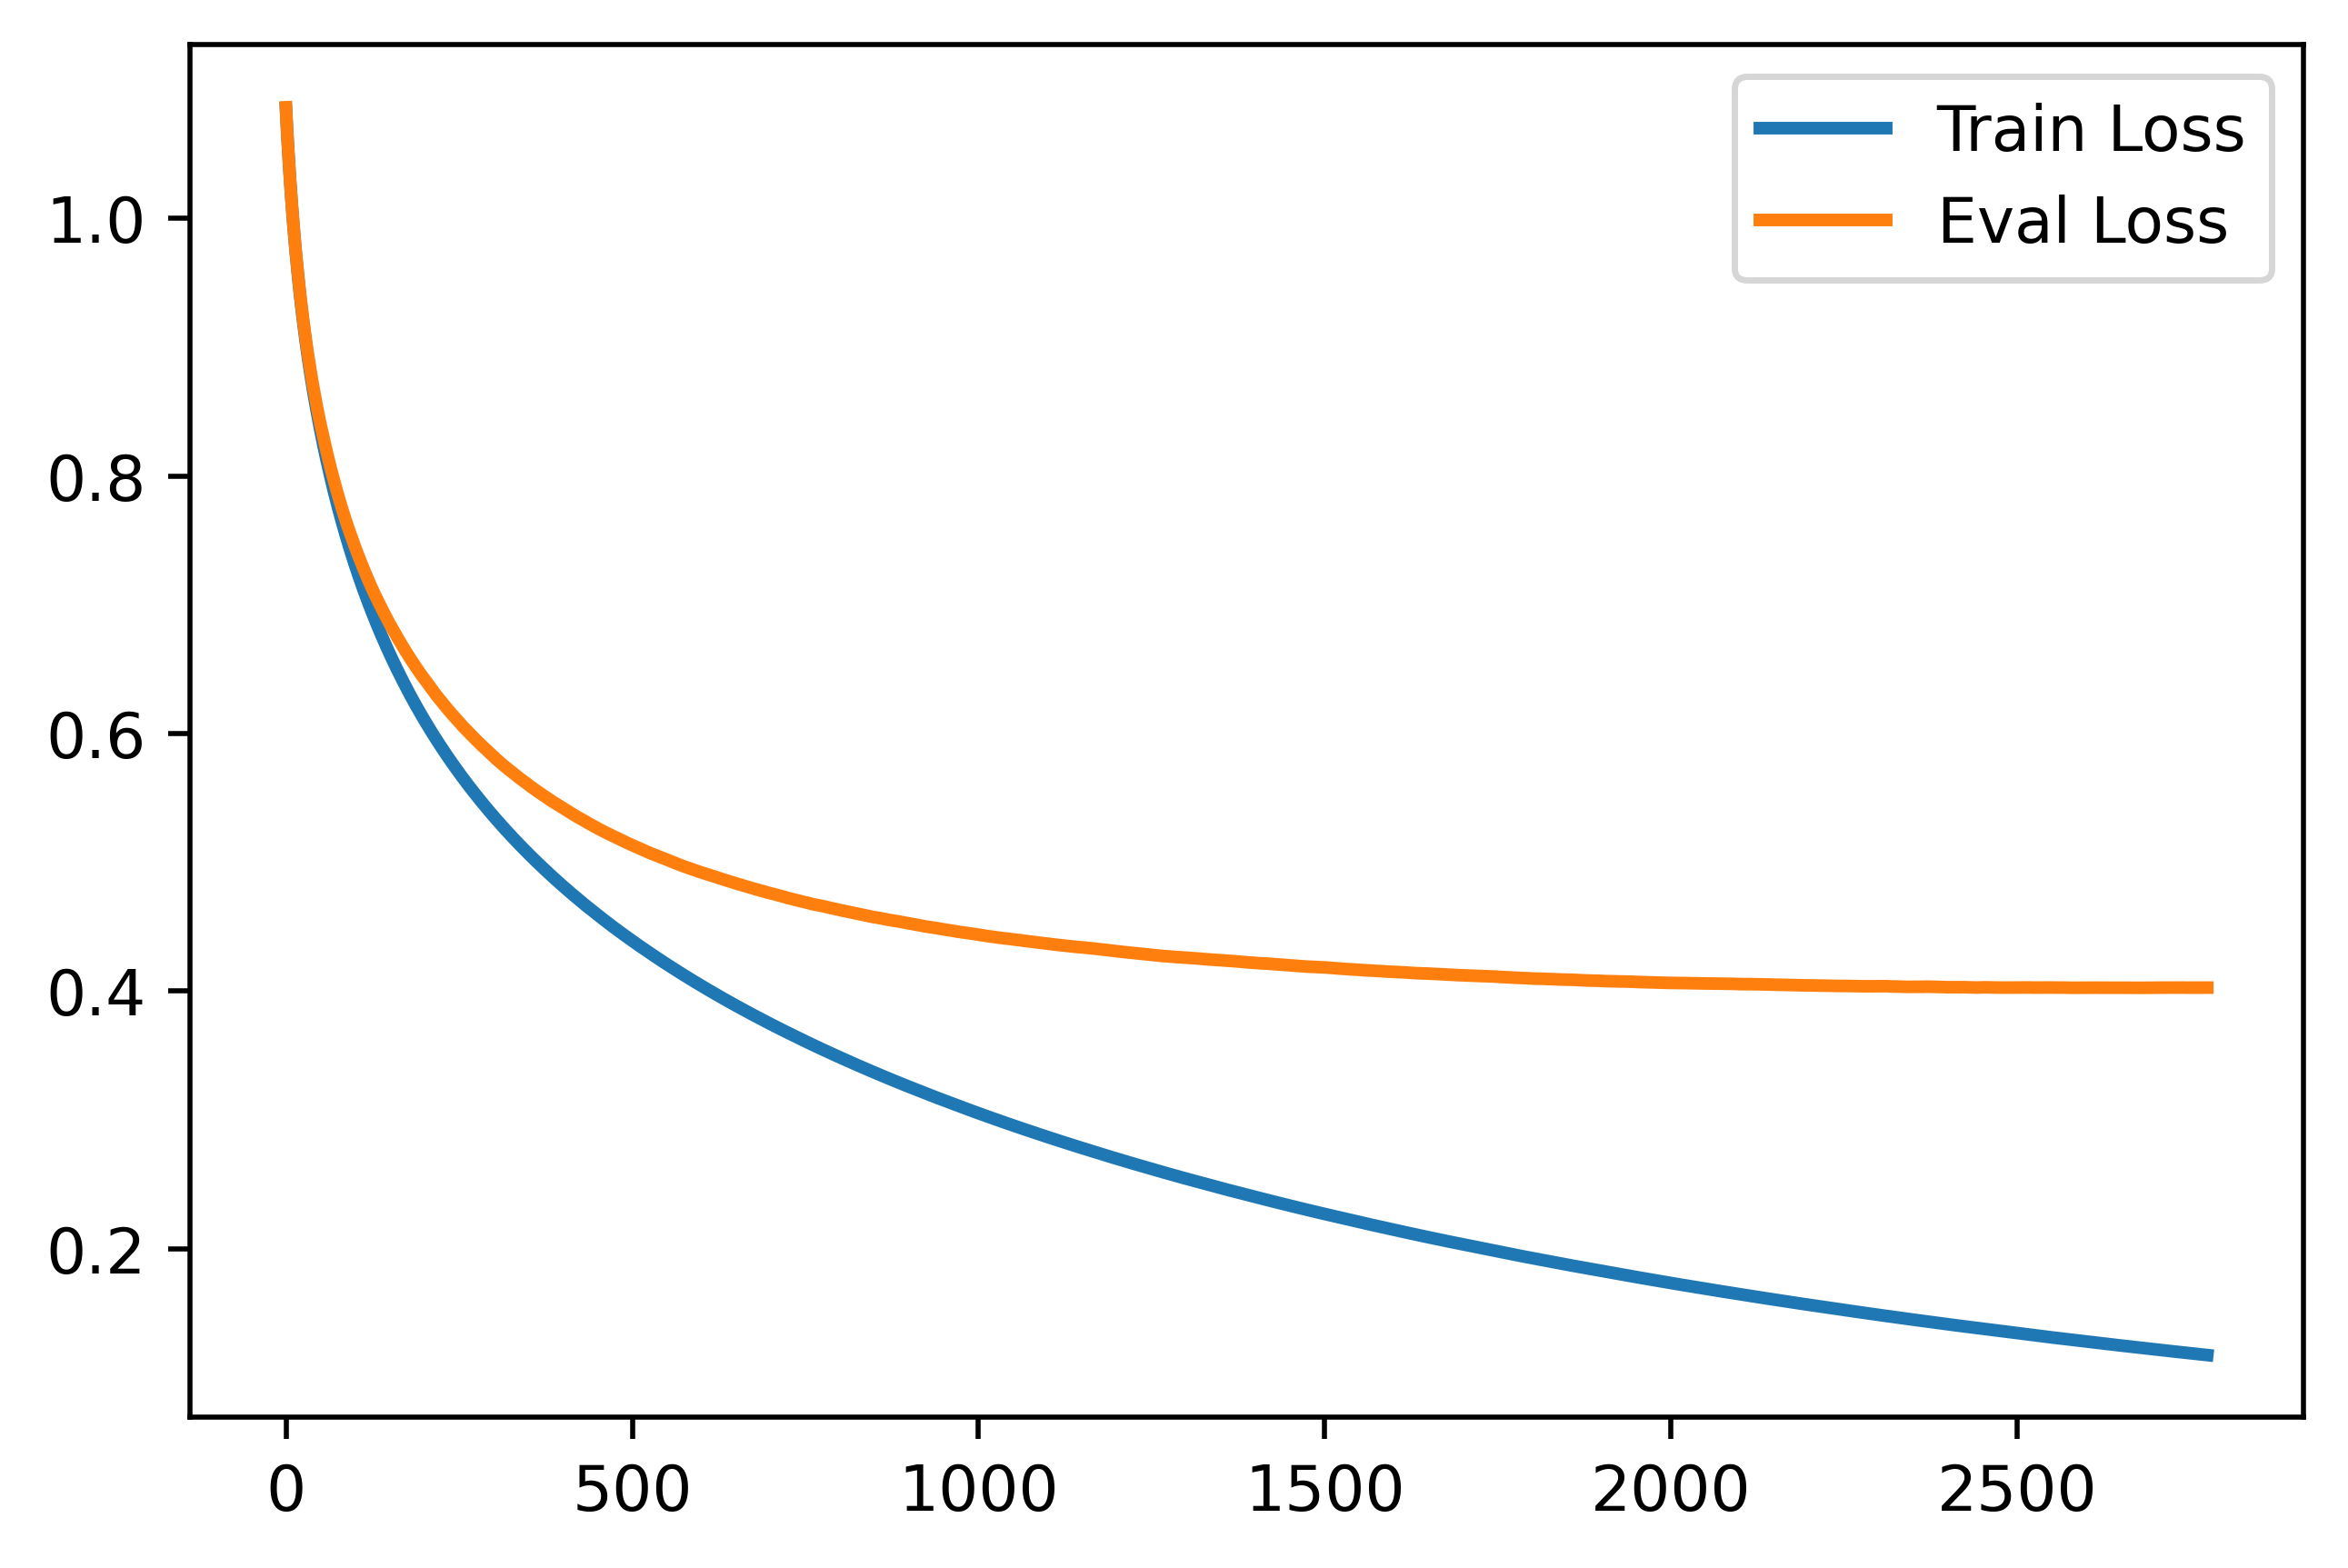

In [18]:
train_loss = eval_result['train']['multi_logloss']
eval_loss = eval_result['validation']['multi_logloss']

plt.figure(figsize=(30,20))
plt.figure(dpi=500)
plt.plot(train_loss,label="Train Loss",linewidth=2)
plt.plot(eval_loss,label="Eval Loss",linewidth=2)
plt.legend()
plt.show()

## Save Model and Test

In [19]:
classifier.booster_.save_model('lgb_classifier_best2.txt', num_iteration=classifier.best_iteration_) 
clf = lgb.Booster(model_file='lgb_classifier_best2.txt')
Y_pred = np.argmax(clf.predict(XTest),axis=1)

## Test Performance : obtains F1 score of 0.84 on test set

In [52]:
print(classification_report(YTest,Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1965
           1       0.85      0.83      0.84      2000
           2       0.83      0.87      0.85      1782

    accuracy                           0.84      5747
   macro avg       0.84      0.84      0.84      5747
weighted avg       0.84      0.84      0.84      5747



## Advantages
- Interpretable , possible to incorporate domain expertise in feature engineering
- Word /Char ngram based features explores morphological differences in surface forms

## Disadvantage
- Prediction ignores syntactic difference in language variants. 

## Future improvements ( Improved Feature Engineering)

- One possible future direction could be predict POS of the sentences. Express sentence as sequence of POS tags and pass sequence through Char CNN which can obtain rich features from cooccuring n-gram POS tags

- Another possible direction could be using TreeLSTM over constitiency graph of sentences to obtain feature representation of each sentence. These individual sentence representation could be aggregated to obtain final feature vector.